In [3]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
from pd_utils import filter_by
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Flipping Factor (FF)
$G = \{\text{group of users}\}$

$Inc(i,G) = \frac {|G_i|}{|G|}$ 

For the sets of users $G_1$ and $G_2$ where $G_1 \cap G_2=\emptyset$ (i.e. gender groups $G_1=Male$ and $G_2=Female$) 

$FF(i, G_1, G_2)= \frac{ Inc(i,G_1) - Inc(i,G_2)}{\max \{ Inc(i,G_1), Inc(i,G_2) \}}$


The idea is to create a two-pass probabilistic perturbation to the original user preference vector $x_u$ (multi-one-hot encoded i.e. MultVAE)

- __Step 1:__ Estimate the anonymity of a user $A(x_u,G_1,G_2) = \frac{1}{|x_u|}\sum_{i\ \in x_u}FF(i,G_1,G_2)$ the closer to cero the more anonymous it is (vulnerability)  
    - User's amount of user interactions 
    - Determine vulnerability of user
    - Threshold on $A(x_u,G_1,G_2)$ 

- __Step 2:__ For a given $x^{\sigma}_u$ subset of the user's interactions $x_u$ we define probabilities $P_{drop}(i)=(1 - |(\text {FF}(x_u,G_1, G_2)|)$ to drop user interactions in $x_u$ during training.
    - Flip coins for each item in $x_u$ to generate  $Mask_{drop}(x^{\sigma}_u) = (\mathrm 1_{i\ \in \ x^{\sigma}_u})\cdot Flip(i, P_{drop}(i))$
- __Step 3:__ Apply $Mask_{drop}(x^{\sigma}_u)$  to  $x_u$   
- __Out :__ Perturbated vector $x'_u$


Privacy criteria intent*:

By fliping specific items in $x_u$ we can achieve debiasing by using a privacy budget $\epsilon$
<!-- __Step :__ Assign the $FF(i, G_1, G_2)$ values to each item $i$ in $x_u$ */-->

In [4]:
#ROOT_DIR = Path(os.getenv('LOCAL_DATASETS'))
ROOT_DIR = Path("/media/gustavo/Storage/Datasets")

In [5]:

import numpy as np
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
from pd_utils import filter_by
import matplotlib.pyplot as plt
def do_something_with_the_group_data(data):
    
    return ""
def item_relative_freq(data):
    # |U_i|/|U|
    print(data.nunique())
    rel_freq = (data.groupby("itemID")["userID"].nunique())/ data["userID"].nunique()
    rel_freq.name="FF"
    print(rel_freq)
    return rel_freq

def calculate_ff(rel_freq, x,y):
    
    common = np.intersect1d(rel_freq[x].index,rel_freq[y].index)
    common_concat = pd.concat([rel_freq[x].loc[common],rel_freq[y].loc[common]],axis=1)
    ff = (rel_freq[x]["FF"].loc[common] - rel_freq[y]["FF"].loc[common])/(1e-24+np.max(common_concat["FF"],axis=1))
    ff.name="FF"
    return ff

def calc_rel_freq(joined, user_groups):
    rel_freq  = {}
    for group, g_values in user_groups.items():
        for g_value in g_values:
            group_data = joined.filter_by([(group,"=",g_value)])
            item_rel_freq = item_relative_freq(group_data)
            item_list=pd.Series(index= joined["itemID"].unique(),data=np.zeros(joined["itemID"].nunique()),name="FF")
            item_list.loc[item_rel_freq.index]=item_rel_freq
            item_list =item_list.to_frame()
            item_list["group"] = g_value
            
            rel_freq[f"{group}_{g_value}"]  = item_list 
    return rel_freq
def calc_rel_freq_inter(joined, user_groups):
    rel_freq  = {}
    for group, g_values in user_groups.items():
        for g_value in g_values:
            group_data = joined.filter_by([(group,"=",g_value)])
            item_rel_freq = item_relative_freq(group_data).to_frame()            
            item_rel_freq["group"] = g_value
            rel_freq[f"{group}_{g_value}"]  = item_rel_freq
    return rel_freq
def sample_most_pop(population, num_sample=5,prob_bins=[], group_key="group"):
    
    return

userID      7580
itemID     99956
freq         521
userIDr     7580
gender         1
dtype: int64
itemID
0        0.001979
1        0.001055
2        0.001979
3        0.004222
4        0.005277
           ...   
99968    0.000528
99969    0.000660
99970    0.000660
99971    0.000528
99972    0.000528
Name: FF, Length: 99956, dtype: float64
userID      1784
itemID     73754
freq         312
userIDr     1784
gender         1
dtype: int64
itemID
0        0.002242
2        0.002242
3        0.000561
4        0.007848
5        0.006726
           ...   
99967    0.001682
99968    0.000561
99970    0.000561
99971    0.000561
99972    0.000561
Name: FF, Length: 73754, dtype: float64


TypeError: savefig() missing 1 required positional argument: 'fname'

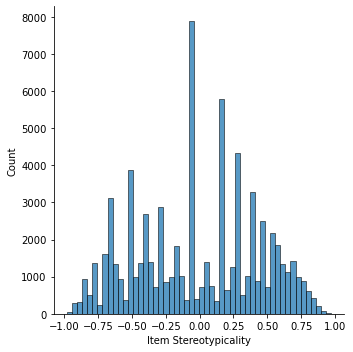

In [7]:

data_inter = pd.read_csv(ROOT_DIR/"lfm-multi-attr/Gustavo-2023-09-v2/inter.tsv.bz2",sep="\t",names=["userID","itemID","freq"],engine="python")
data_user = pd.read_csv(ROOT_DIR/"lfm-multi-attr/Gustavo-2023-09-v2/demo.tsv.bz2",sep="\t",names=["userID","country","age","gender","created_at"],engine="python")

joined = data_inter.join(data_user[["userID","gender"]], on="userID",how="left", lsuffix='', rsuffix='r').dropna()

user_groups= {"gender":["m","f"]}
rel_freq  = calc_rel_freq_inter(joined,user_groups)
ff =calculate_ff(rel_freq,"gender_m","gender_f")
#ff.to_csv("lastfm-ff-values-M2F.csv")
ff.name = "Item Stereotypicality"
sns.displot(ff)
plt.savefig()
plt.title("Distribution of item's FF values")

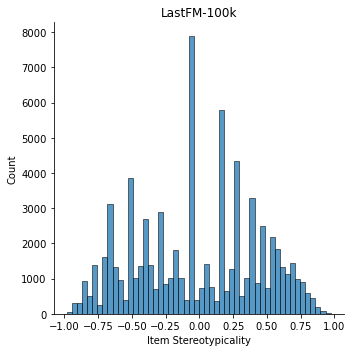

In [10]:

sns.displot(ff)
plt.title("LastFM-100k")
plt.tight_layout()
plt.savefig("figures/lfm_item_ster.png",dpi=250)


In [28]:

calculate_ff(rel_freq,"gender_m","gender_f")

itemID
0       -0.117414
2       -0.117414
3        0.867223
4       -0.327554
5        0.427117
           ...   
99967   -0.843096
99968   -0.058575
99970    0.150224
99971   -0.058575
99972   -0.058575
Name: FF, Length: 73737, dtype: float64

In [26]:
rel_freq['gender_m']

,FF,group
itemID,,
0,0.001979,m
1,0.001055,m
2,0.001979,m
3,0.004222,m
4,0.005277,m
...,...,...
99968,0.000528,m
99969,0.000660,m
99970,0.000660,m


      index        FF group
0      1193  0.286770     M
2462   1647  0.016163     M
2464   1053  0.005311     M
2465    384  0.006465     M
2466   2458  0.023782     M
...     ...       ...   ...
1238    659  0.002342     F
1239   2202  0.038642     F
1240   1267  0.124122     F
1241   1199  0.160422     F
3705   2909  0.000585     F

[7412 rows x 3 columns]


/tmp/ipykernel_31069/417193113.py:7: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=inc_data,x="index",y="FF",hue="group",palette=pallete)


Text(0, 0.5, '$Item\\ Inclination$')

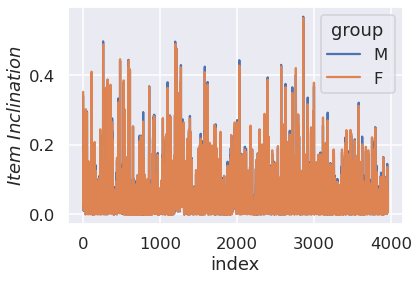

In [71]:
sns.set_theme("talk")
fig = plt.Figure()
pallete=sns.color_palette()
inc_data =  pd.concat([v.reset_index() for k,v in rel_freq.items()]).sort_values("group",ascending=False)

print(inc_data)
sns.lineplot(data=inc_data,x="index",y="FF",hue="group",palette=pallete)

plt.ylabel("$Item\ Inclination$")

userID         6040
itemID         3706
rating            5
timestamp    458455
dtype: int64
userID         4331
itemID         3668
rating            5
timestamp    331338
userIDr        4331
gender            1
dtype: int64
userID         1708
itemID         3518
rating            5
timestamp    131578
userIDr        1708
gender            1
dtype: int64
itemID
1   -0.034392
2    0.077474
3    0.140556
4   -0.105092
5    0.243734
Name: FF, dtype: float64


Text(0.5, 1.0, "Distribution of item's FF values")

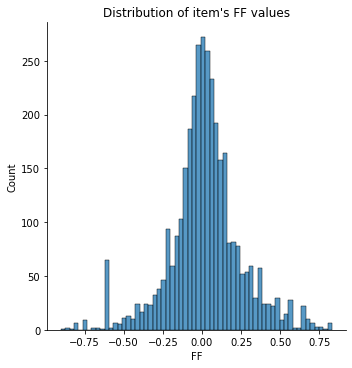

In [5]:


data_inter = pd.read_csv(ROOT_DIR/"ml-1m/ratings.dat",sep="::",names=["userID","itemID","rating","timestamp"],engine="python")
data_user = pd.read_csv(ROOT_DIR/"ml-1m/users.dat",sep="::",names=["userID","gender","age","occcupation","zipcode"],engine="python")

joined = data_inter.join(data_user[["userID","gender"]], on="userID",how="left", lsuffix='', rsuffix='r').dropna()
user_groups= {"gender":["M","F"]}
rel_freq  = calc_rel_freq_inter(joined,user_groups)
ff =calculate_ff(rel_freq,"gender_M","gender_F")
ff.name="FF"
print(ff.head())
ff.to_csv("ml-1m-ff-values.csv")
sns.displot(ff)
plt.title("Distribution of item's FF values")

In [20]:

data_inter.merge(data_user,on="userID")

,userID,itemID,rating,timestamp,gender,age,occcupation,zipcode
0,1,1193,5,978300760,F,1,10,48067
1,1,661,3,978302109,F,1,10,48067
2,1,914,3,978301968,F,1,10,48067
3,1,3408,4,978300275,F,1,10,48067
4,1,2355,5,978824291,F,1,10,48067
...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,M,25,6,11106
1000205,6040,1094,5,956704887,M,25,6,11106
1000206,6040,562,5,956704746,M,25,6,11106
1000207,6040,1096,4,956715648,M,25,6,11106


Text(0, 0.5, '$Item\\ Inclination$')

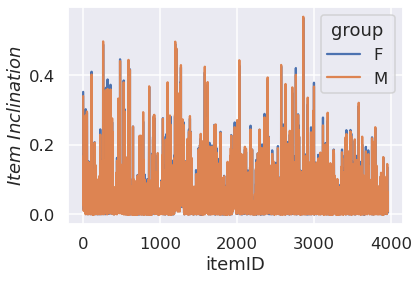

In [13]:
sns.set_theme("talk")
fig = plt.Figure()
inc_data =  pd.concat([v.reset_index() for k,v in rel_freq.items()]).sort_values("group",ascending=True)
sns.lineplot(data=inc_data,x="itemID",y="userID",hue="group")

plt.ylabel("$Item\ Inclination$")

ff

In [ ]:
ff_values = calculate_ff()
# min 20 interactions per user
# sample size should be 10% of the total number of user interactions
# methods include: imputate, remove, replace** 
# anonymity threshold  should be in [0,1] ~ It can also be based on the median of the distribution of user's ff average score




def calculate_anonymity(x_u, ff_values):
    return np.mean(x_u * ff_values)

def obfuscate_ff(x_u,ff_values,sample_size, method="random", action="drop",anonymity_thresh=0.5):
    # mapping items
    x_u_index, _ = np.nonzero(x_u)
    ff_x_u = ff_values * x_u
    ff_items = ff_x_u[x_u_index]
        
    # establish anonymity of the user
    if calculate_anonymity(x_u,ff_values) <= anonymity_thresh:
        # generate subset of items 
        if method == "random": 
            mask=np.choice(ff_items, sample_size,replace=False)
        else if method == "topk"
            mask=np.argpartition(ff_items, -sample_size)[-sample_size:]
        else if method == "flip-coin":
            flip_coins = np.array([np.binomial(1,p,1) for p in ff_items])
            mask = np.argpartition(flip_coins, -sample_size)[-sample_size:]
        else:
            raise Exception("Not implemented sampling method")
        
        # perform action    
        if action == "drop":
            x_u [mask] = 0.0
        else if action == "imputate"
            x_u [mask] = 1.0
        else if action == "replace"
            pass
        
    return x_u


In [87]:
x= np.array([0,1,0,1])
np.where(x>0)[0]

array([1, 3])

Hold-out 20% of each user's interactions
Generate different versions of the same datasets under differente paramtrizations of the mechanism
 
 

 
 
 Results should inlcude a table indicating comparison of
 
 - Original algorithms
 - PerBlur Variants
     - Imputate
     - Remove
 - Our Approach
     - Imputate
     -  Remove
 The attacking phase can have two approaches:
 - Attack latent representations
    - user embeddings: BPR , LightGCN
    - latent representation MultVAE
 - Attack preferences vectors 
    - Multt-one-hot encoded preference vectors
 
     











In [3]:
%%writefile data_utils.py
import numpy as np
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
from pd_utils import filter_by
import matplotlib.pyplot as plt

def split_by_inter_ratio(data, ratio=0.8, random_state=42,user_key="userID"
                        ):
    np.random.seed(random_state)
    data = data.sort_values([user_key],ascending=True)
    grouped = data.groupby(user_key).apply(lambda x : x.head(int(ratio * len(x))).index.values)
    indexes_train = np.concatenate(grouped.values)
    data["tr"] = False
    data.loc[indexes_train,"tr"] = True
    return data

def transform_to_recbole(data):
    recbole_map = {
        'userID':      'user_id:token',
        'itemID':     'item_id:token',
        #'timestamp':    'timestamp:float',
        }
    data = data.rename(recbole_map)
    return data
    
    
    
    

Overwriting data_utils.py


In [4]:
%%writefile  obfuscation.py
import numpy as np
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
from pd_utils import filter_by
import matplotlib.pyplot as plt

def perform_action(user_data, sample, method="remove"):
    #print([sample,user_data])
    if method == "remove":
        user_data= np.setdiff1d(user_data,sample)
    elif method == "imputate":
        #print(user_data)
        user_data = np.concatenate((user_data, sample))
        
    else:
        raise Exception("Not implemented action method!")
    
    return user_data

def perform_sub_sampling(user_data,ff_values,method="topk", k=50, p_sample=0.1):
    if method == "topk":
        ff_user_data= ff_values.loc[user_data].sort_values(ascending=False)
        size_sample = int(p_sample * len(user_data))
        if size_sample<=k:
            top_k = ff_user_data[:size_sample]
        else:
            top_k = ff_user_data[:k]
        user_data = topk    
    elif method == "random":
        user_data = np.random.choice(user_data, int(p_sample * len(user_data)),replace=False)
    elif method == "ff":
        user_data = np.random.choice(user_data, int(p_sample * len(user_data)),replace=False)
        #print(ff_values.loc[user_data])
        coins = np.array([np.random.binomial(1,np.abs(p),1)[0] for p in ff_values.loc[user_data]])
        #print([len(user_data),coins,np.nonzero(coins)])
        user_data = user_data[np.nonzero(coins)[0]]
        
    else:
        raise Exception("Not implemented sampling method!")
        
    return user_data

def calc_user_stereotyp_pref(ff_values, method="mean"):
    user_stereo = -1.05
    if len(ff_values>0):
        if method == "mean":
            user_stereo = np.mean(ff_values)
        elif method == "median":
            user_stereo = np.median(ff_values)
        elif method == "diff":
            user_stereo = np.sum((np.where(ff_values>=0))- np.sum(np.abs(np.where(ff_values<0))))/2
        else :
            raise Exception("Not implemented stereotypical user preferences measure")

    return user_stereo


def obfuscate_user_data(user_data,ff_data,method,sub_method, k, p_sample,sterotyp_method):
    
    valid_user_items = np.intersect1d(user_data["itemID"].values,ff_data.index.values)
    user_ff_values = ff_data.loc[valid_user_items,"FF"]
    # Estimating the stereotypicallity of the user profile
    user_stereo_pref = calc_user_stereotyp_pref(user_ff_values.values,method=sterotyp_method)
    if (abs(user_stereo_pref) > user_stereo_pref_thresh):
        # Sampling from user profile
        user_sampled = perform_sub_sampling(user_data=valid_user_items, ff_values=user_ff_values, method=sub_method, k=topk, p_sample=p_SAMPLE)
        # Perform obfuscation
        obfuscated_user_data = perform_action(valid_user_items, user_sampled,method=method)
    
        return obfuscated_user_data
    else:
        return user_data
        
def obfuscate_data(train_data, users, p_SAMPLE = 0.15, topk=50, method = "remove",sub_method = "ff",sterotyp_method="mean",user_stereo_pref_thresh = 0.01):
    n_obfuscated = 0
    users_obfuscated = []
    for user in users:
        # Select user data from the whole training set
        user_data = train_data.loc[train_data["userID"]==user]
        # Selecting only items that have defined FF values from the user profile
        valid_user_items = np.intersect1d(user_data["itemID"].values,ff_data.index.values)
        user_ff_values = ff_data.loc[valid_user_items,"FF"]
        # Estimating the stereotypicallity of the user profile
        user_stereo_pref = calc_user_stereotyp_pref(user_ff_values.values,method=sterotyp_method)
        
        # Sampling for users that have reached stereotypical preference threshold 
        if (abs(user_stereo_pref) > user_stereo_pref_thresh):
            n_obfuscated += 1
            # Sampling from user profile
            user_sampled = perform_sub_sampling(user_data=valid_user_items, ff_values=user_ff_values, method=sub_method, k=topk, p_sample=p_SAMPLE)
            # Perform obfuscation
            obfuscated_user_data = perform_action(valid_user_items, user_sampled,method=method)
            users_obfuscated.append([user, list(obfuscated_user_data)])
        else:
            users_obfuscated.append([user, list(user_data["itemID"])])
            
    obfuscated_data = pd.DataFrame(data=users_obfuscated,columns=["userID","itemID"]).explode("itemID")
    print([len(train_data), len(users), p_SAMPLE, topk, method,sub_method,user_stereo_pref_thresh,n_obfuscated,len(obfuscated_data)])
    return obfuscated_data

def plot_user_score(data,ff_data, user_features,title, method):
    joined = data_inter.join(data_user[["userID","gender"]], on="userID",how="left", lsuffix='', rsuffix='r').dropna()
    joined["user_ff_score"]= joined["itemID"].apply(lambda x: ff_data["FF"].get(x,None))
    joined= joined.dropna()
    mean_user=joined.groupby(["userID","gender"])["user_ff_score"].apply(lambda x:calc_user_stereotyp_pref(x,method)).reset_index()
    sns.displot(data=mean_user, x="user_ff_score",hue="gender")
    plt.title(title)
    plt.show()
    
def plot_user_median_score(data,ff_data, user_features,title):
    joined = data_inter.join(data_user[["userID","gender"]], on="userID",how="left", lsuffix='', rsuffix='r').dropna()
    joined["user_ff_score"]= joined["itemID"].apply(lambda x: ff_data["FF"].get(x,None))
    mean_user=joined.groupby(["userID","gender"])["user_ff_score"].median().reset_index()
    sns.displot(data=mean_user, x="user_ff_score",hue="gender")
    plt.title(title)
    plt.show()                     

Writing obfuscation.py


In [426]:

import numpy as np
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
from pd_utils import filter_by
import matplotlib.pyplot as plt
# Spliting original data by interactions
data_inter = pd.read_csv(ROOT_DIR/"ml-1m/ratings.dat",sep="::",names=["userID","itemID","rating","timestamp"],engine="python")
ff_data = pd.read_csv("ml-1m-ff-values.csv",index_col="itemID")
processed = split_by_inter_ratio(data_inter)

processed = processed.join(ff_data["itemID"], on="userID",how="left", lsuffix='', rsuffix='r').dropna()

train_data = processed[processed["tr"]]

test_data = processed[~processed["tr"]]
users = train_data["userID"].unique()


In [427]:
datasets = {
#"mean_remove_ff":obfuscate_data(train_data, users, p_SAMPLE = 0.15, topk=50, method = "remove",sub_method = "ff",sterotyp_method="mean",user_stereo_pref_thresh = 0.005),
#"mean_remove_random":obfuscate_data(train_data, users, p_SAMPLE = 0.50, topk=50, method = "remove",sub_method = "random",sterotyp_method="mean",user_stereo_pref_thresh = 0.005),
"mean_remove_topk":obfuscate_data(train_data, users, p_SAMPLE = 0.10, topk=50, method = "remove",sub_method = "topk",sterotyp_method="mean",user_stereo_pref_thresh = 0.005),
"diff_remove_topk":obfuscate_data(train_data, users, p_SAMPLE = 0.10, topk=50, method = "remove",sub_method = "topk",sterotyp_method="diff",user_stereo_pref_thresh = 0.015),    
    
    
#"median_remove_ff":obfuscate_data(train_data, users, p_SAMPLE = 0.10, topk=50, method = "remove",sub_method = "ff",sterotyp_method="median",user_stereo_pref_thresh = 0.005),
#"median_remove_random":obfuscate_data(train_data, users, p_SAMPLE = 0.10, topk=50, method = "remove",sub_method = "random",sterotyp_method="median",user_stereo_pref_thresh = 0.005),
"median_remove_topk":obfuscate_data(train_data, users, p_SAMPLE = 0.10, topk=50, method = "remove",sub_method = "topk",sterotyp_method="median",user_stereo_pref_thresh = 0.005),

#"imputate_ff":obfuscate_data(train_data, users, p_SAMPLE = 0.15, topk=50, method = "imputate",sub_method = "ff",user_stereo_pref_thresh = 0.05),
#"imputate_random":obfuscate_data(train_data, users, p_SAMPLE = 0.15, topk=50, method = "imputate",sub_method = "random",user_stereo_pref_thresh = 0.05)
}

[797758, 6040, 0.1, 50, 'remove', 'topk', 0.005, 4884, 796321]
[797758, 6040, 0.1, 50, 'remove', 'topk', 0.015, 6039, 795943]
[797758, 6040, 0.1, 50, 'remove', 'topk', 0.005, 4787, 796392]


In [420]:
data_inter = pd.read_csv(ROOT_DIR/"ml-1m/ratings.dat",sep="::",names=["userID","itemID","rating","timestamp"],engine="python")
data_user = pd.read_csv(ROOT_DIR/"ml-1m/users.dat",sep="::",names=["userID","gender","age","occcupation","zipcode"],engine="python")

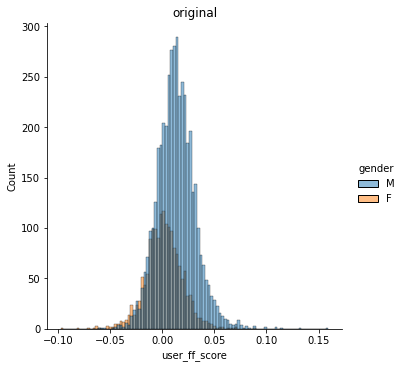

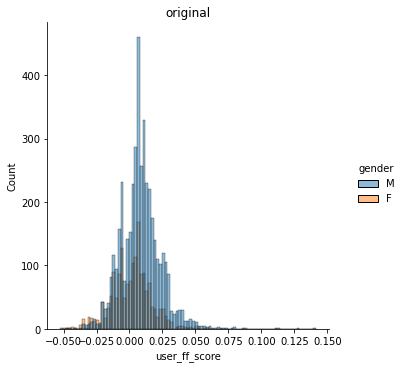

[None, None]

In [428]:
[plot_user_score(data_inter,ff_data,data_user,"original","mean"),
 plot_user_score(data_inter,ff_data,data_user,"original","median")]

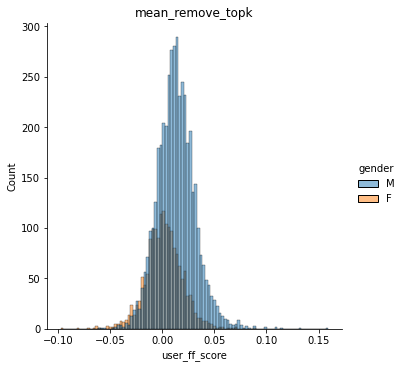

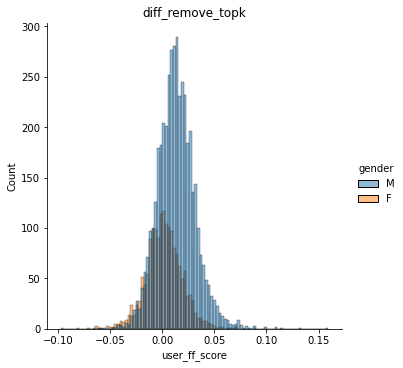

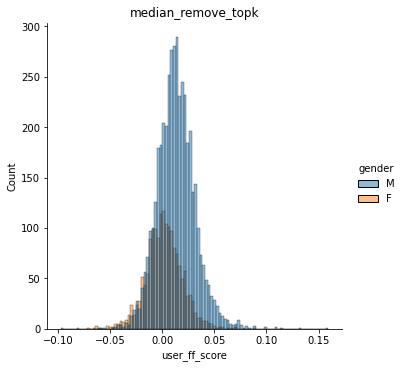

[None, None, None]

In [425]:
[plot_user_score(data,ff_data,data_user,k,"mean") for k,data in datasets.items()]


In [ ]:
[plot_user_median_score(data,ff_data,data_user,k) for k,data in datasets.items()]

In [395]:
# Spliting original data by interactions
data_inter = pd.read_csv(ROOT_DIR/"lfm-multi-attr/Gustavo-2023-09-v2/inter.tsv.bz2",sep="\t",names=["userID","itemID","freq"],engine="python")
data_user = pd.read_csv(ROOT_DIR/"lfm-multi-attr/Gustavo-2023-09-v2/demo.tsv.bz2",sep="\t",names=["userID","country","age","gender","created_at"],engine="python")


ff_data = pd.read_csv("lastfm-ff-values-M2F.csv",index_col="itemID")
processed = split_by_inter_ratio(data_inter)


train_data = processed[processed["tr"]]
test_data = processed[~processed["tr"]]
users = train_data["userID"].unique()

In [396]:
datasets = {
"mean_remove_ff":obfuscate_data(train_data, users, p_SAMPLE = 0.15, topk=50, method = "remove",sub_method = "ff",sterotyp_method="mean",user_stereo_pref_thresh = 0.005),
"mean_remove_random":obfuscate_data(train_data, users, p_SAMPLE = 0.50, topk=50, method = "remove",sub_method = "random",sterotyp_method="mean",user_stereo_pref_thresh = 0.005),
"mean_remove_topk":obfuscate_data(train_data, users, p_SAMPLE = 0.10, topk=50, method = "remove",sub_method = "topk",sterotyp_method="mean",user_stereo_pref_thresh = 0.005),
    
"median_remove_ff":obfuscate_data(train_data, users, p_SAMPLE = 0.10, topk=50, method = "remove",sub_method = "ff",sterotyp_method="median",user_stereo_pref_thresh = 0.005),
"median_remove_random":obfuscate_data(train_data, users, p_SAMPLE = 0.10, topk=50, method = "remove",sub_method = "random",sterotyp_method="median",user_stereo_pref_thresh = 0.005),
"median_remove_topk":obfuscate_data(train_data, users, p_SAMPLE = 0.10, topk=50, method = "remove",sub_method = "topk",sterotyp_method="median",user_stereo_pref_thresh = 0.005),

#"imputate_ff":obfuscate_data(train_data, users, p_SAMPLE = 0.15, topk=50, method = "imputate",sub_method = "ff",user_stereo_pref_thresh = 0.05),
#"imputate_random":obfuscate_data(train_data, users, p_SAMPLE = 0.15, topk=50, method = "imputate",sub_method = "random",user_stereo_pref_thresh = 0.05)
}

/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/

[1452976, 9364, 0.15, 50, 'remove', 'ff', 0.005, 9197, 1220347]


/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/

[1452976, 9364, 0.5, 50, 'remove', 'random', 0.005, 9197, 660714]


/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/

[1452976, 9364, 0.1, 50, 'remove', 'topk', 0.005, 9197, 1291256]


/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/

[1452976, 9364, 0.1, 50, 'remove', 'ff', 0.005, 9261, 1243158]


/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/

[1452976, 9364, 0.1, 50, 'remove', 'random', 0.005, 9261, 1166522]


/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gustavo/anaconda3/envs/recbole/lib/python3.8/site-packages/

[1452976, 9364, 0.1, 50, 'remove', 'topk', 0.005, 9261, 1290067]


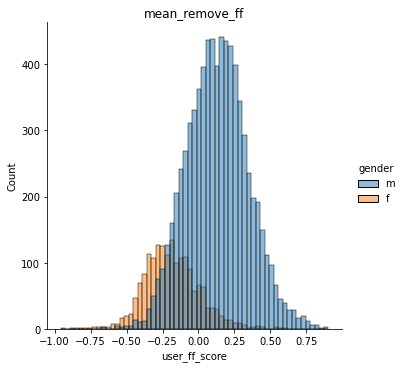

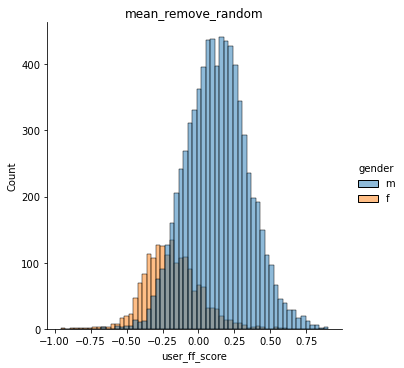

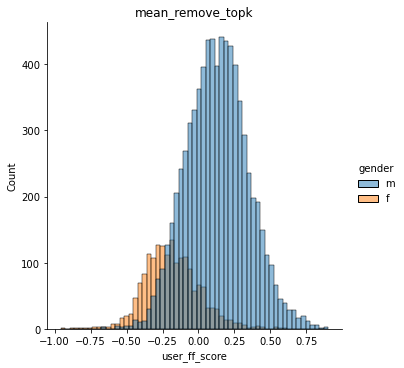

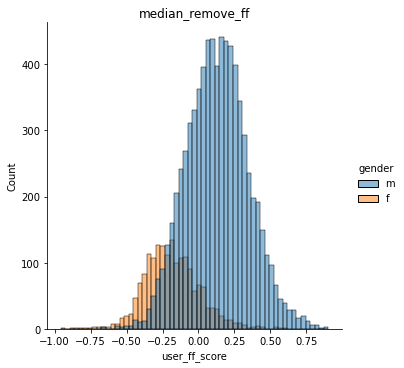

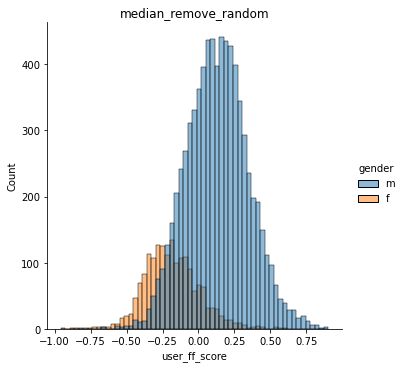

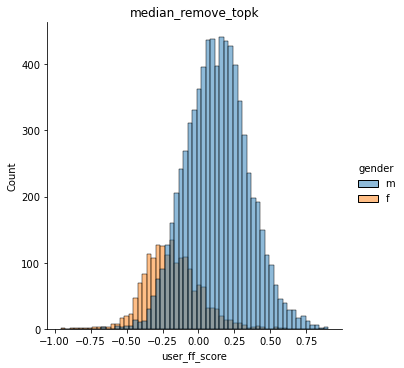

[None, None, None, None, None, None]

In [397]:
[plot_user_mean_score(data,ff_data,data_user,k) for k,data in datasets.items()]

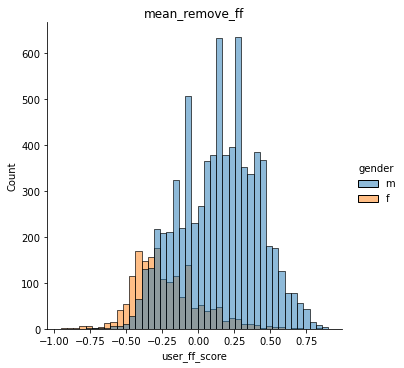

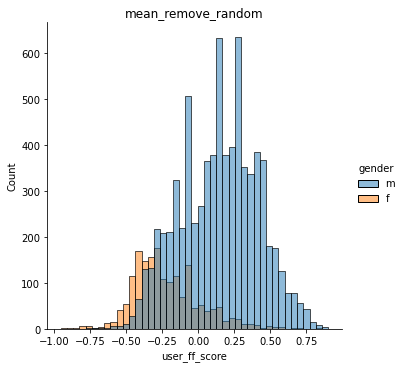

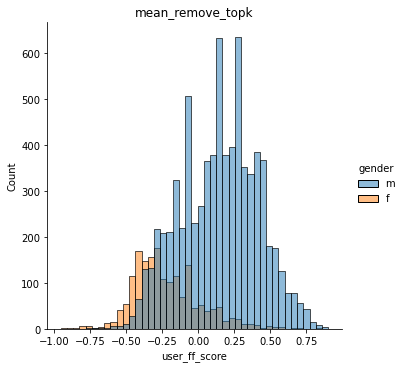

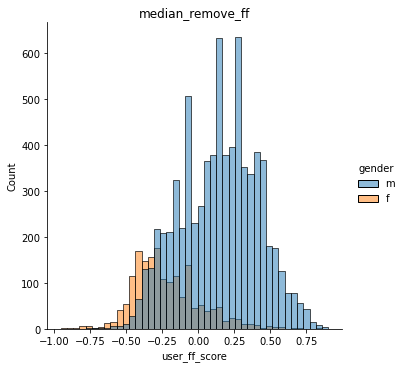

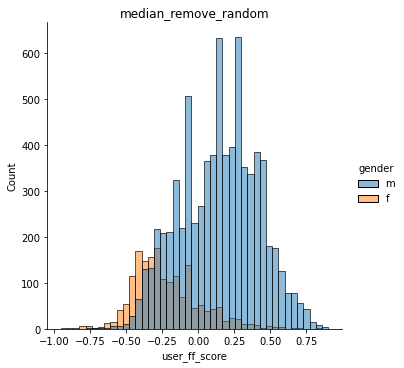

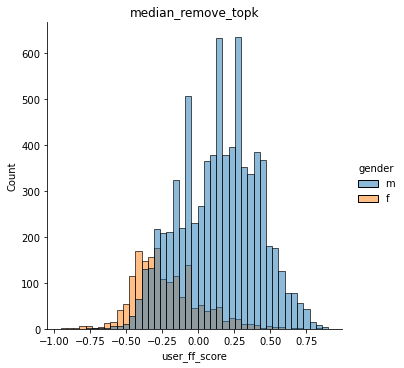

[None, None, None, None, None, None]

In [398]:
[plot_user_median_score(data,ff_data,data_user,k) for k,data in datasets.items()]

- DP-SGD
- tCDP
- TAN
- Adv-MultVAE



- Take the perspective of the item 

- Generate new roles for 